In [8]:
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
from mlflow import list_run_infos
from urllib.parse import urlparse, unquote_plus
import pandas as pd
import seaborn as sn

In [11]:
# Get experiment
# NOTE: Make sure your CWD is set to the directory where your mlruns/ folder is located.

# import os
# print(os.getcwd()) # Shows the CWD
# os.chdir(NEW_PATH) # Sets the CWD to an arbitrary path.

client = MlflowClient()
experiment = client.get_experiment_by_name("Durable_SA_determ_run_June3_DQNbasic")

In [31]:
exp_id = experiment.experiment_id
runs = list_run_infos(exp_id)
runs = sorted(runs, key=lambda r: r.end_time)
latest_run = runs[-1]
artifact_uri = unquote_plus(urlparse(str(latest_run.artifact_uri)).path)
progress_path = artifact_uri + "/progress.csv"
#print(artifact_uri)
progress = pd.read_csv(progress_path)
progress

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,agent_timesteps_total,done,episodes_total,...,info/num_target_updates,perf/cpu_util_percent,perf/ram_util_percent,info/learner/default_policy/allreduce_latency,info/learner/default_policy/grad_gnorm,info/learner/default_policy/cur_lr,info/learner/default_policy/mean_q,info/learner/default_policy/min_q,info/learner/default_policy/max_q,info/learner/default_policy/mean_td_error
0,NaN,NaN,NaN,NaN,0,12,1008,1008,False,0,...,1,51.500000,60.50,0.0,10.930940,0.1,0.351552,-0.443828,1.062381,2.608645
1,-213.461122,-293.253994,-249.198359,100.0,24,12,3024,3024,False,24,...,4,42.150000,60.45,0.0,95.835180,0.1,-47.226734,-48.059288,-46.217388,-8.456989
2,-202.647402,-293.253994,-249.623926,100.0,24,12,5040,5040,False,48,...,8,38.350000,60.05,0.0,77.147224,0.1,-26.623180,-30.969227,-24.344919,-2.869802
3,-198.119465,-293.253994,-247.149620,100.0,12,12,7056,7056,False,60,...,12,47.100000,59.45,0.0,26.183079,0.1,-19.058128,-22.313789,-15.062149,-0.420523
4,-198.119465,-309.489010,-249.406633,100.0,24,12,9072,9072,False,84,...,16,44.200000,59.00,0.0,39.066030,0.1,-17.645399,-21.591160,-14.227229,0.636100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2876,-19.210316,-28.976619,-22.847353,100.0,12,12,2996784,2996784,False,29964,...,5674,44.133333,59.00,0.0,0.037869,0.1,-5.887589,-5.974903,-5.862484,-0.030219
2877,-19.210316,-29.134642,-22.418106,100.0,12,12,2997792,2997792,False,29976,...,5676,43.633333,59.00,0.0,0.039140,0.1,-5.827694,-5.845011,-5.806681,-0.021309
2878,-19.210316,-29.134642,-21.619947,100.0,12,12,2998800,2998800,False,29988,...,5678,43.633333,59.00,0.0,0.062804,0.1,-5.766457,-5.905853,-5.736855,0.042403
2879,-19.210316,-29.134642,-21.619947,100.0,0,12,2999808,2999808,False,29988,...,5680,42.700000,59.00,0.0,0.069868,0.1,-5.658591,-5.792285,-5.646412,0.053735


<AxesSubplot:xlabel='episodes_total', ylabel='episode_reward_mean'>

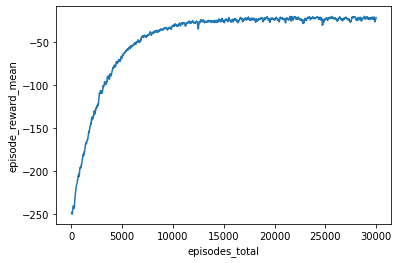

In [13]:
sn.lineplot(data=progress, x="episodes_total",y="episode_reward_mean")

2021-06-07 18:21:08,848	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-06-07 18:21:09,051	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/Durable_SA_endTTB_sm_test_June7_DQN/DQN_Durable_SA_endTTB_56f32_00000_0_2021-06-07_15-55-42/checkpoint_000040/checkpoint-40
2021-06-07 18:21:09,053	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 639.5534262657166, '_episodes_total': 2000}


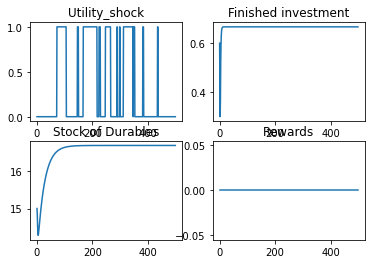

In [36]:
#Step 4: Evaluation
from marketsai.markets.durable_sa_endTTB import Durable_SA_endTTB
from ray.rllib.agents.dqn import DQNTrainer
from ray.tune.registry import register_env
from ray import shutdown, init
import matplotlib.pyplot as plt

config_analysis = {
    "env": "Durable_SA_endTTB",
    "horizon": 100,
    "soft_horizon": True,
    "no_done_at_end": True,
    "explore": False,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [128, 128],
    },
}

#checkpoint_path = results.best_checkpoint
register_env("Durable_SA_endTTB", Durable_SA_endTTB)
env = Durable_SA_endTTB()
checkpoint_path = "/Users/matiascovarrubias/ray_results/Durable_SA_endTTB_sm_test_June7_DQN/DQN_Durable_SA_endTTB_56f32_00000_0_2021-06-07_15-55-42/checkpoint_000040/checkpoint-40"
trained_trainer = DQNTrainer(env="Durable_SA_endTTB", config=config_analysis)
trained_trainer.restore(checkpoint_path)
inv_list = []
h_list = []
rew_list = []
shock_list = []
progress_list = []
obs = env.reset()
MAX_STEPS = 500
for i in range(MAX_STEPS):
    action = trained_trainer.compute_action(obs)
    obs, rew, done, info = env.step(action)
    inv_list.append(info["investment"])
    h_list.append(obs[0][0])
    shock_list.append(obs[1])
    rew_list.append(rew)
    progress_list.append(obs[0][1:])

plt.subplot(2, 2, 1)
plt.plot(shock_list)
plt.title("Utility_shock")

plt.subplot(2, 2, 2)
plt.plot(inv_list)
plt.title("Finished investment")

plt.subplot(2, 2, 3)
plt.plot(h_list)
plt.title("Stock of Durables")

plt.subplot(2, 2, 4)
plt.plot(rew_list)
plt.title("Rewards")

plt.savefig("endTTB_test_IR.png")
plt.show()

# IRresults = {
#     "investment": inv_list,
#     "durable_stock": h_list,
#     "reward": rew_list,
#     "progress_list": progress_list,
# }
# df_IR = pd.DataFrame(IRresults)
# df_IR.to_csv("Durable_SA_endTTB_test_June7_DQN.csv")

shutdown()